In [1]:
import pandas as pd
import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import xgboost as xgb
from sklearn.metrics import mean_squared_error

# Load the dataset
data_path = 'USD_NGN Historical Data.csv'
df = pd.read_csv(data_path)

# Display the first few rows of the dataset
df.head()


,Date,Price,Open,High,Low,Vol.,Change %
0,07/05/2024,"1,535.000","1,535.000","1,540.175","1,474.000",NaN,0.00%
1,07/04/2024,"1,535.000","1,535.000","1,537.925","1,502.925",NaN,0.00%
2,07/03/2024,"1,535.000","1,535.000","1,537.925","1,474.000",NaN,0.00%
3,07/02/2024,"1,535.000","1,525.000","1,535.000","1,470.345",NaN,0.66%
4,07/01/2024,"1,525.000","1,513.730","1,533.865","1,465.845",NaN,0.00%


In [2]:
# cleaning the price column
df['Price'] = df['Price'].str.replace(',', '')
df['Price'] = df['Price'].astype(float)

df = df[['Date', 'Price']]

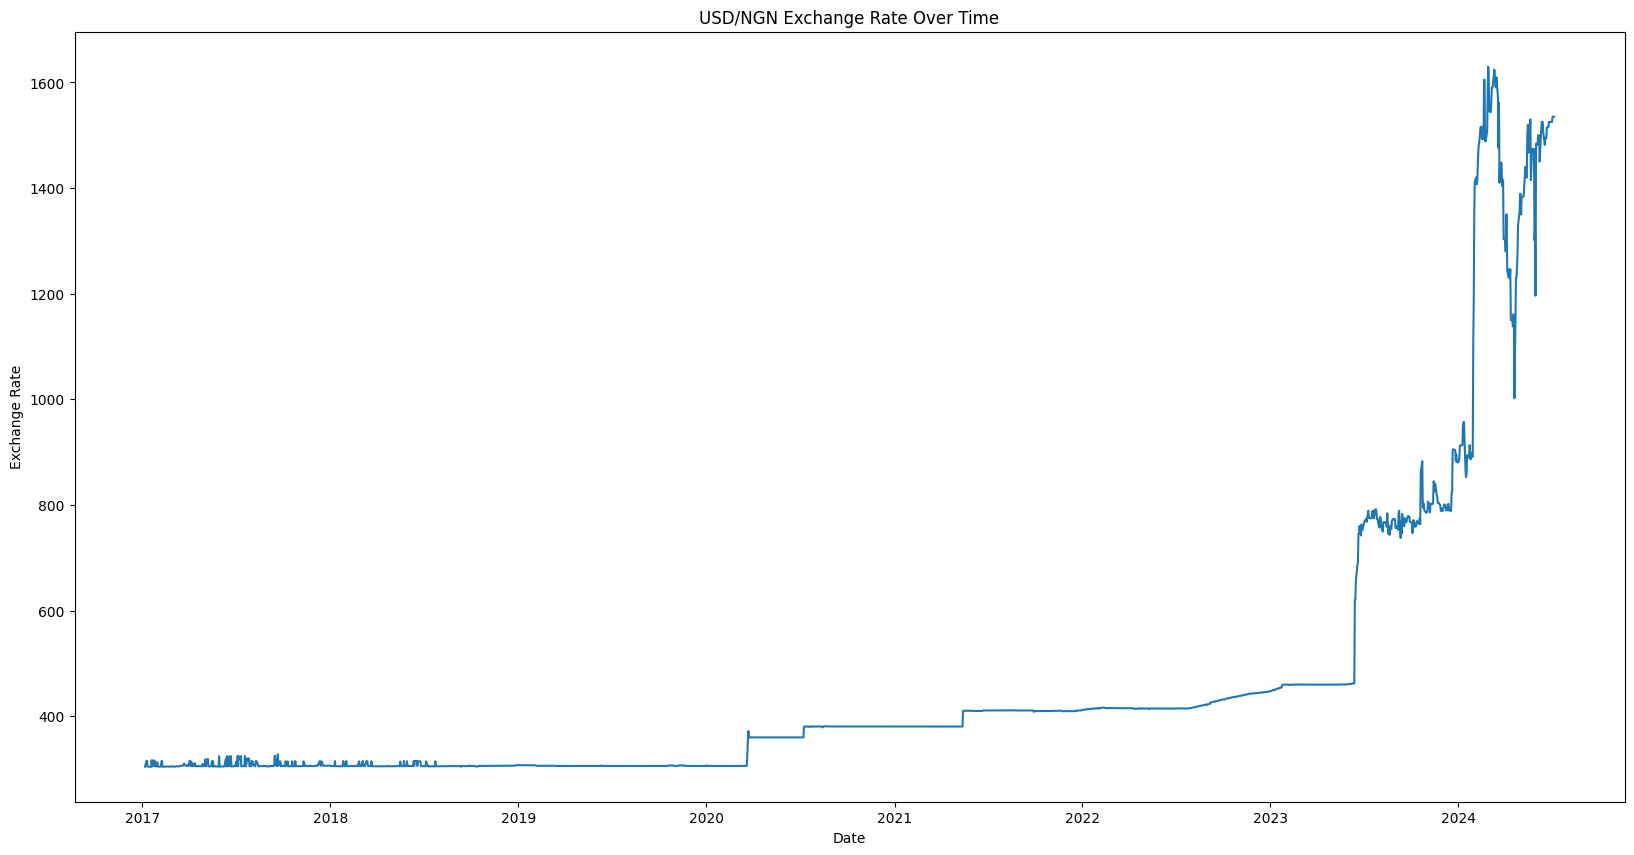

In [3]:
# Convert the date column to datetime
df['Date'] = pd.to_datetime(df['Date'])

# Sort the dataframe by date
df = df.sort_values('Date')

# Plot the time series
plt.figure(figsize=(20, 10))
plt.plot(df['Date'], df['Price'])
plt.xlabel('Date')
plt.ylabel('Exchange Rate')
plt.title('USD/NGN Exchange Rate Over Time')
plt.show()


In [4]:
# Create lag features
for lag in range(1, 31):
    df[f'lag_{lag}'] = df['Price'].shift(lag)

# Create rolling mean features
df['rolling_mean_7'] = df['Price'].rolling(window=7).mean()
df['rolling_mean_14'] = df['Price'].rolling(window=14).mean()
df['rolling_mean_21'] = df['Price'].rolling(window=21).mean()
df['rolling_mean_30'] = df['Price'].rolling(window=30).mean()
# reset the index
df = df.reset_index(drop=True)

In [5]:
df.head()

,Date,Price,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,lag_7,lag_8,...,lag_25,lag_26,lag_27,lag_28,lag_29,lag_30,rolling_mean_7,rolling_mean_14,rolling_mean_21,rolling_mean_30
0,2017-01-06,304.500,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2017-01-09,315.590,304.500,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2017-01-10,315.465,315.590,304.500,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2017-01-11,304.500,315.465,315.590,304.50,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2017-01-12,304.500,304.500,315.465,315.59,304.5,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [6]:
df.isna().sum() 

Date                0
Price               0
lag_1               1
lag_2               2
lag_3               3
lag_4               4
lag_5               5
lag_6               6
lag_7               7
lag_8               8
lag_9               9
lag_10             10
lag_11             11
lag_12             12
lag_13             13
lag_14             14
lag_15             15
lag_16             16
lag_17             17
lag_18             18
lag_19             19
lag_20             20
lag_21             21
lag_22             22
lag_23             23
lag_24             24
lag_25             25
lag_26             26
lag_27             27
lag_28             28
lag_29             29
lag_30             30
rolling_mean_7      6
rolling_mean_14    13
rolling_mean_21    20
rolling_mean_30    29
dtype: int64

In [7]:
df.shape

(1955, 36)

In [8]:
# Drop rows with NaN values
df_1 = df.dropna()
df_1.shape

(1925, 36)

In [9]:
# Define features and target variable
features = [col for col in df_1.columns if col not in ['Date', 'Price']]
X = df_1[features]
y = df_1['Price']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.05, shuffle=False)

In [10]:
X_train.head()

,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,lag_7,lag_8,lag_9,lag_10,...,lag_25,lag_26,lag_27,lag_28,lag_29,lag_30,rolling_mean_7,rolling_mean_14,rolling_mean_21,rolling_mean_30
30,304.95,304.95,304.50,304.50,304.50,304.70,315.79,314.75,304.75,304.75,...,304.50,304.5,304.5,315.465,315.590,304.500,304.728571,306.238571,307.688095,307.892500
31,305.00,304.95,304.95,304.50,304.50,304.50,304.70,315.79,314.75,304.75,...,304.50,304.5,304.5,304.500,315.465,315.590,304.764286,306.252857,307.686667,307.537833
32,304.95,305.00,304.95,304.95,304.50,304.50,304.50,304.70,315.79,314.75,...,304.70,304.5,304.5,304.500,304.500,315.465,304.792857,306.252857,307.114048,307.179000
33,304.70,304.95,305.00,304.95,304.95,304.50,304.50,304.50,304.70,315.79,...,304.70,304.7,304.5,304.500,304.500,304.500,304.821429,306.249286,307.058810,307.185667
34,304.70,304.70,304.95,305.00,304.95,304.95,304.50,304.50,304.50,304.70,...,316.87,304.7,304.7,304.500,304.500,304.500,304.850000,306.245714,306.585238,307.192333


In [11]:
X_train.shape, X_test.shape

((1828, 34), (97, 34))

In [12]:
X_test.tail()

,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,lag_7,lag_8,lag_9,lag_10,...,lag_25,lag_26,lag_27,lag_28,lag_29,lag_30,rolling_mean_7,rolling_mean_14,rolling_mean_21,rolling_mean_30
1950,1525.0,1525.0,1525.0,1525.0,1515.0,1515.0,1495.0,1495.0,1495.0,1481.64,...,1474.0,1474.0,1467.0,1440.0,1415.0,1529.85,1522.142857,1512.617143,1506.840000,1473.824667
1951,1525.0,1525.0,1525.0,1525.0,1525.0,1515.0,1515.0,1495.0,1495.0,1495.00,...,1301.0,1474.0,1474.0,1467.0,1440.0,1415.00,1525.000000,1513.331429,1509.363810,1477.824667
1952,1535.0,1525.0,1525.0,1525.0,1525.0,1525.0,1515.0,1515.0,1495.0,1495.00,...,1320.0,1301.0,1474.0,1474.0,1467.0,1440.00,1527.857143,1514.045714,1511.030476,1480.991333
1953,1535.0,1535.0,1525.0,1525.0,1525.0,1525.0,1525.0,1515.0,1515.0,1495.00,...,1196.1,1320.0,1301.0,1474.0,1474.0,1467.00,1529.285714,1516.188571,1512.697143,1483.258000
1954,1535.0,1535.0,1535.0,1525.0,1525.0,1525.0,1525.0,1525.0,1515.0,1515.00,...,1484.0,1196.1,1320.0,1301.0,1474.0,1474.00,1530.714286,1520.000000,1514.363810,1485.291333


In [13]:
# Define the XGBoost regressor
xgb_reg = xgb.XGBRegressor(objective='reg:squarederror', n_estimators=1000, learning_rate=0.1, max_depth=5)

# Train the model
xgb_reg.fit(X_train, y_train)

# Make predictions
y_pred = xgb_reg.predict(X_test)

# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
print(f'Mean Squared Error: {mse}')

Mean Squared Error: 20209.54282656097


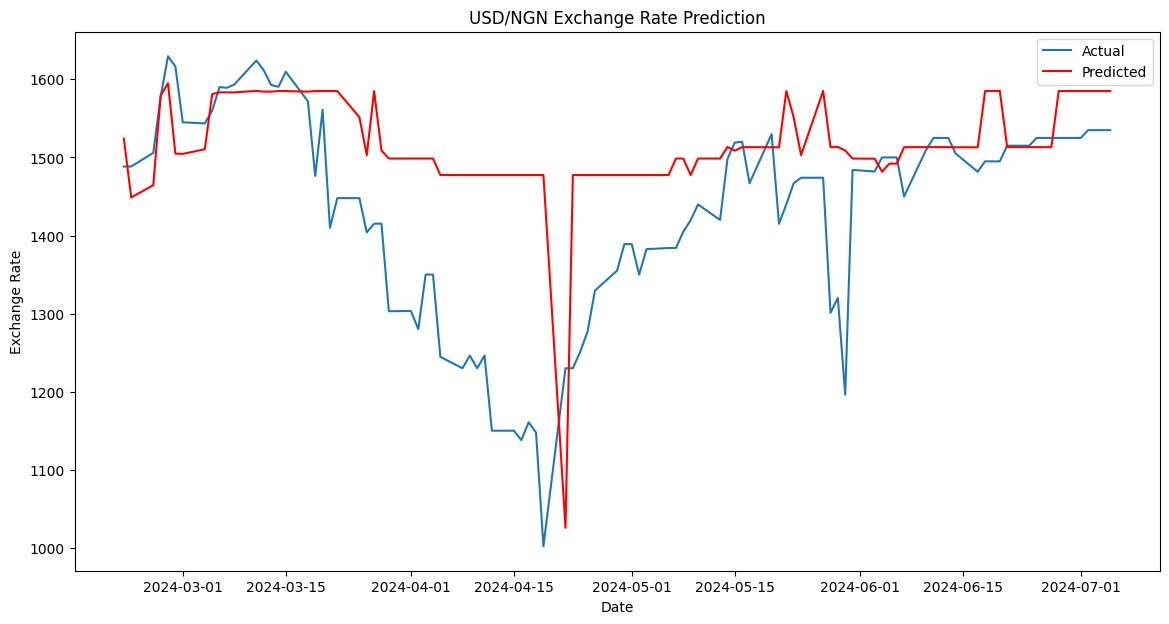

In [14]:
# Plot the actual vs predicted values
plt.figure(figsize=(14, 7))
plt.plot(df['Date'][-len(y_test):], y_test, label='Actual')
plt.plot(df['Date'][-len(y_test):], y_pred, label='Predicted', color='red')
plt.xlabel('Date')
plt.ylabel('Exchange Rate')
plt.title('USD/NGN Exchange Rate Prediction')
plt.legend()
plt.show()


In [20]:
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV

# Define the parameter grid
param_grid = {
    'n_estimators': [100, 200, 1000],
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 5, 7],
}

# Time series split
tscv = TimeSeriesSplit(n_splits=5)

# Grid search
grid_search = GridSearchCV(estimator=xgb_reg, param_grid=param_grid, cv=tscv, scoring='neg_mean_squared_error')
grid_search.fit(X_train, y_train)

# Best parameters
best_params = grid_search.best_params_
print(f'Best parameters: {best_params}')

# Train the best model
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)

# Evaluate the best model
mse = mean_squared_error(y_test, y_pred)
print(f'Mean Squared Error: {mse}')

Best parameters: {'learning_rate': 0.1, 'max_depth': 7, 'n_estimators': 1000}
Mean Squared Error: 17189.752623519544


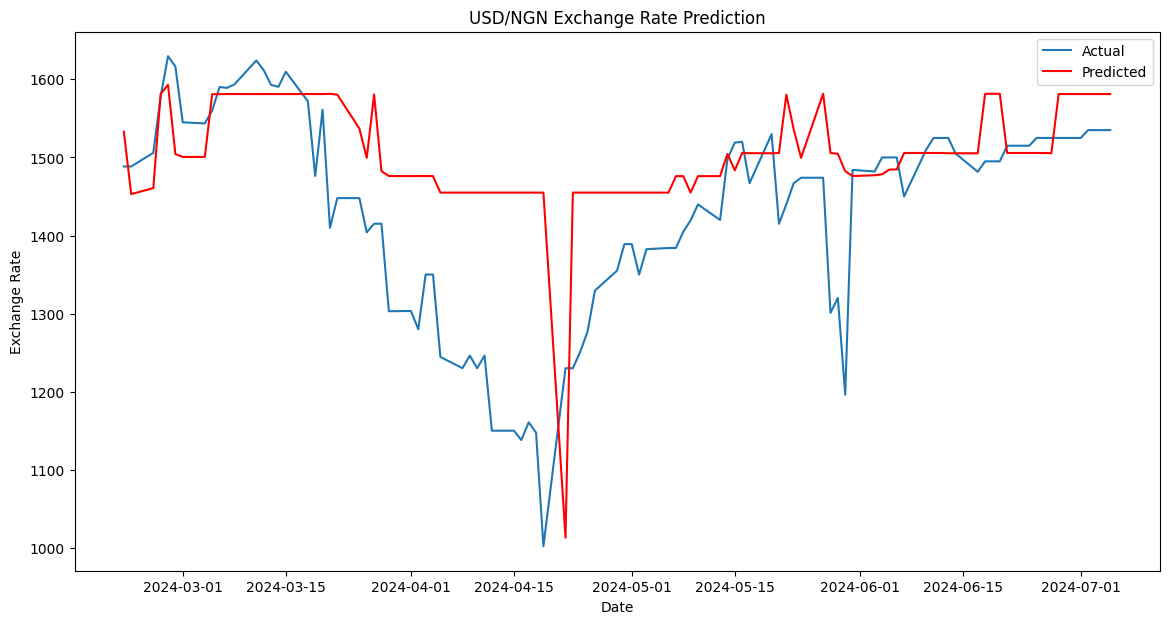

In [21]:
# Plot the actual vs predicted values
plt.figure(figsize=(14, 7))
plt.plot(df['Date'][-len(y_test):], y_test, label='Actual')
plt.plot(df['Date'][-len(y_test):], y_pred, label='Predicted', color='red')
plt.xlabel('Date')
plt.ylabel('Exchange Rate')
plt.title('USD/NGN Exchange Rate Prediction')
plt.legend()
plt.show()

In [24]:
from sklearn.ensemble import RandomForestRegressor
import catboost  as cb
import lightgbm as lgb

XGBoost Mean Squared Error: 19863.060218881295


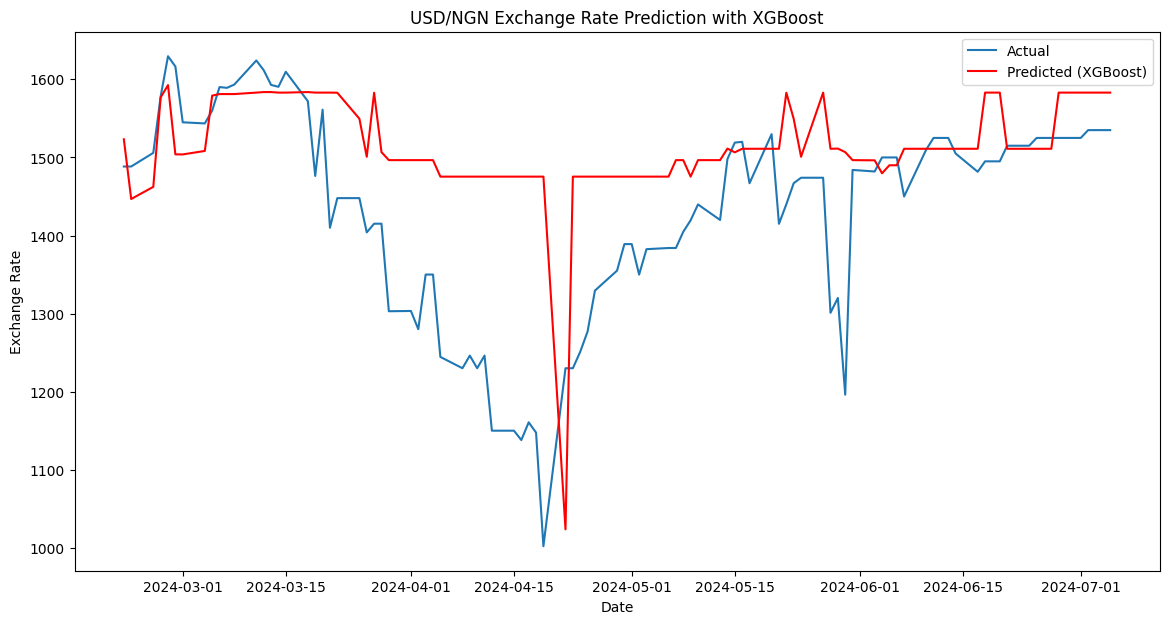

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003112 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 8632
[LightGBM] [Info] Number of data points in the train set: 1828, number of used features: 34
[LightGBM] [Info] Start training from score 408.096760
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain

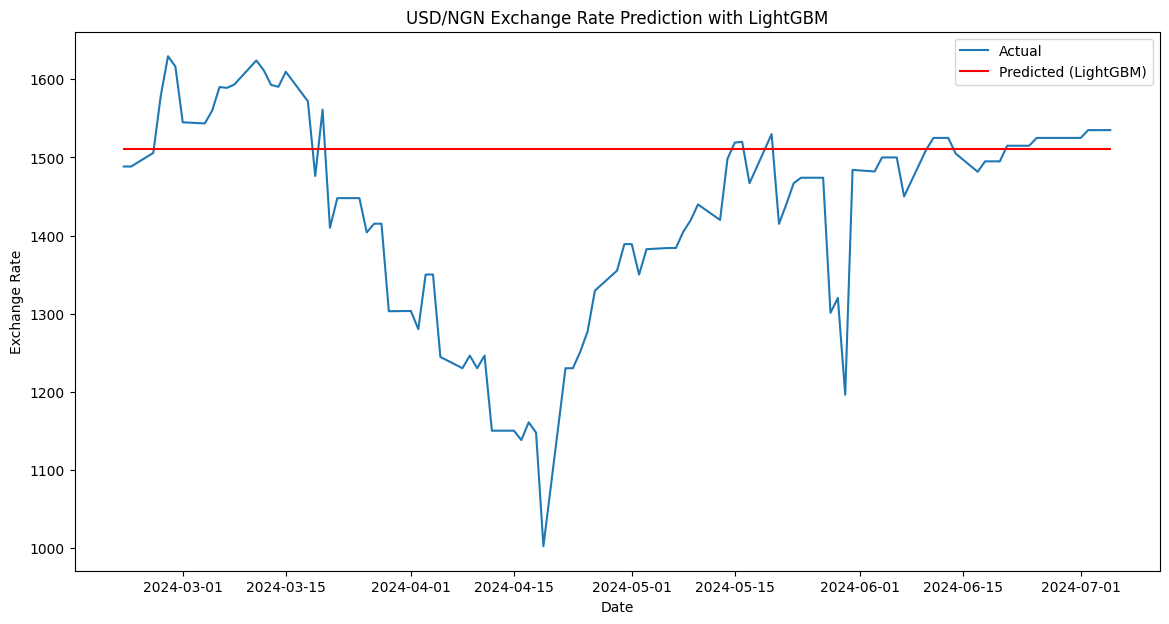

CatBoost Mean Squared Error: 27909.06387123952


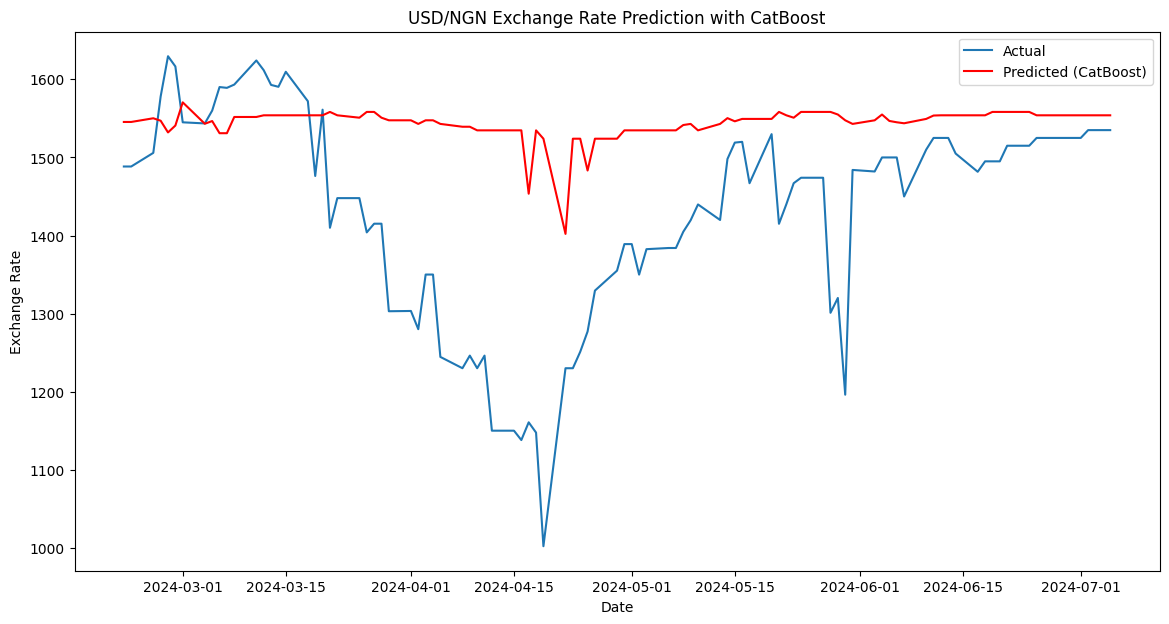

RandomForest Mean Squared Error: 16342.918783845667


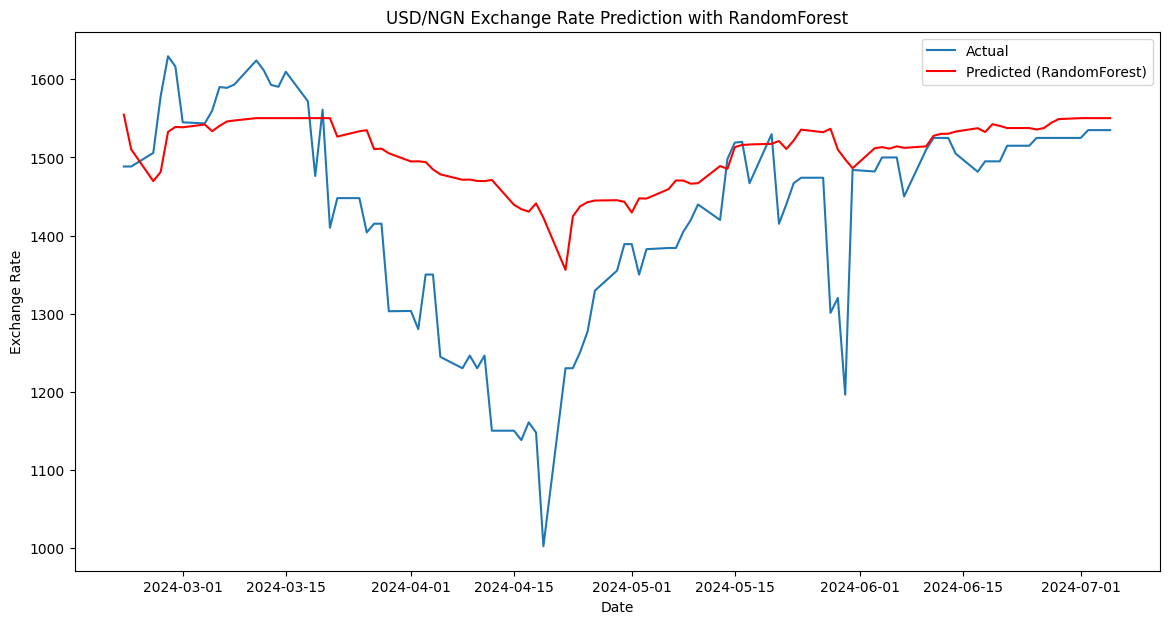

In [25]:
# Define models
models = {
    "XGBoost": xgb.XGBRegressor(objective='reg:squarederror', n_estimators=100, learning_rate=0.1, max_depth=5),
    "LightGBM": lgb.LGBMRegressor(n_estimators=100, learning_rate=0.1, max_depth=5),
    "CatBoost": cb.CatBoostRegressor(iterations=100, learning_rate=0.1, depth=5, verbose=0),
    "RandomForest": RandomForestRegressor(n_estimators=100, max_depth=5, random_state=42)
}

# Train and evaluate each model
for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    print(f'{name} Mean Squared Error: {mse}')

    # Plot the actual vs predicted values
    plt.figure(figsize=(14, 7))
    plt.plot(df['Date'][-len(y_test):], y_test, label='Actual')
    plt.plot(df['Date'][-len(y_test):], y_pred, label=f'Predicted ({name})', color='red')
    plt.xlabel('Date')
    plt.ylabel('Exchange Rate')
    plt.title(f'USD/NGN Exchange Rate Prediction with {name}')
    plt.legend()
    plt.show()


Best XGBoost parameters: {'learning_rate': 0.1, 'max_depth': 7, 'n_estimators': 300}
Best XGBoost Mean Squared Error: 17187.960521609955


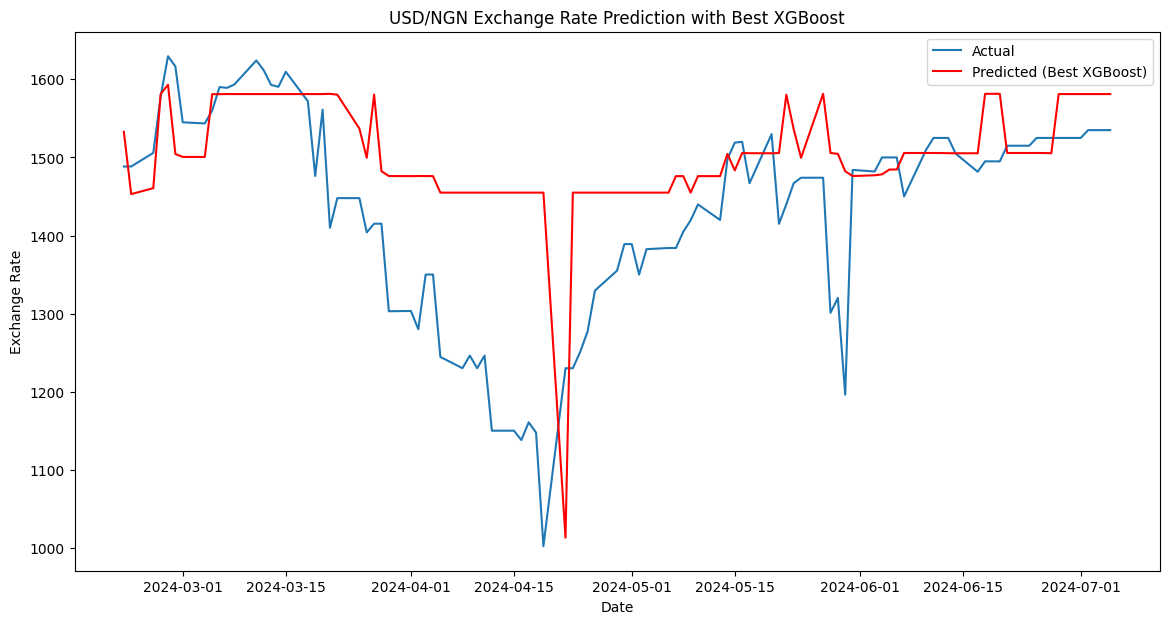

In [26]:
# Example for XGBoost
param_grid_xgb = {
    'n_estimators': [100, 200, 300],
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 5, 7],
}

tscv = TimeSeriesSplit(n_splits=5)
grid_search_xgb = GridSearchCV(estimator=xgb.XGBRegressor(objective='reg:squarederror'), param_grid=param_grid_xgb, cv=tscv, scoring='neg_mean_squared_error')
grid_search_xgb.fit(X_train, y_train)
best_xgb = grid_search_xgb.best_estimator_
print(f'Best XGBoost parameters: {grid_search_xgb.best_params_}')

# Train the best model
best_xgb.fit(X_train, y_train)
y_pred = best_xgb.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
print(f'Best XGBoost Mean Squared Error: {mse}')

# Plot the actual vs predicted values
plt.figure(figsize=(14, 7))
plt.plot(df['Date'][-len(y_test):], y_test, label='Actual')
plt.plot(df['Date'][-len(y_test):], y_pred, label='Predicted (Best XGBoost)', color='red')
plt.xlabel('Date')
plt.ylabel('Exchange Rate')
plt.title('USD/NGN Exchange Rate Prediction with Best XGBoost')
plt.legend()
plt.show()
